In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Dataset visualization

## Returns of each stock

In [3]:
from library.dataset import get_prices, get_log_returns

# Load returns
df_returns_real = get_log_returns(get_prices())
tickers = df_returns_real.columns

Chosen tickers: ['LKOH', 'SBERP', 'VTBR', 'SBER', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577


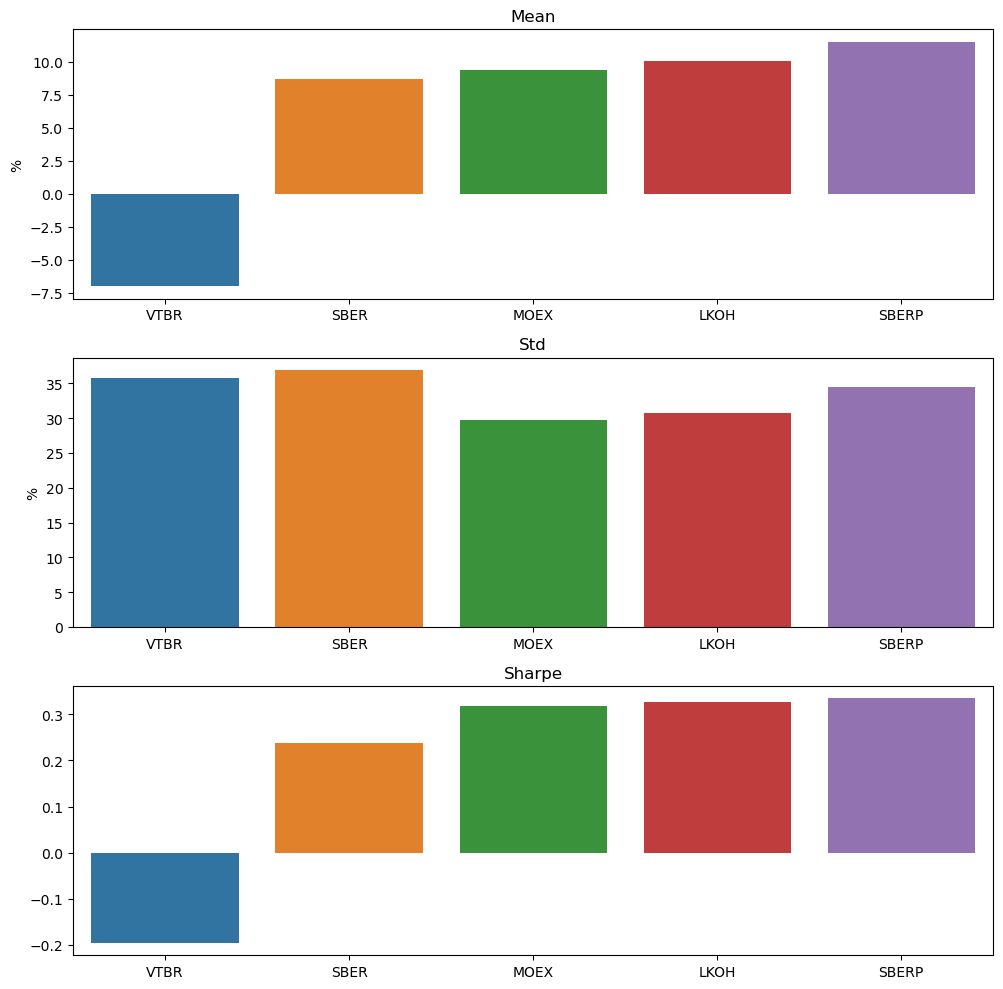

In [4]:
from library.portfolio import plot_tickers_performance

plot_tickers_performance(df_returns_real)

## Returns correlation matrix

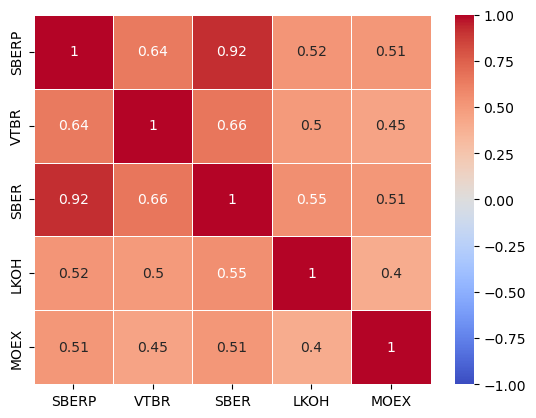

In [5]:
from library.correlations import plot_correlation_matrix

sorted_tickers = plot_correlation_matrix(df_returns_real.corr())

# Generated returns test

In [9]:
from library.gan_train_loop import load_gan
from library.gan import Generator
from library.constants import DEVICE

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=800)

Load 800 epoch checkpoint


In [36]:
from library.generation import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

df_returns_fake_list = [generate_fake_returns(generator, df_returns_real, seed=i) for i in tqdm(range(100))]

  0%|          | 0/100 [00:00<?, ?it/s]

## Equal portfolio

In [44]:
from library.portfolio import get_returns, print_statistics, plot_cumulative_returns
from library.momentum import get_equal_portfolio

w = get_equal_portfolio(df_returns_real.columns)

equal_w_real_returns = get_returns(w, df_returns_real)
equal_w_fake_returns = get_returns(w, df_returns_fake)

print('Real:')
print_statistics(equal_w_real_returns)
print('\nFake:')
print_statistics(equal_w_fake_returns)

Real:
Annual Return (mean ± std): 6.7% ± 27.3%
Sharpe: 0.24
Annual Mean Return 95% confidence interval: 6.66%±16.74%

Fake:
Annual Return (mean ± std): 6.5% ± 25.9%
Sharpe: 0.25
Annual Mean Return 95% confidence interval: 6.51%±15.87%


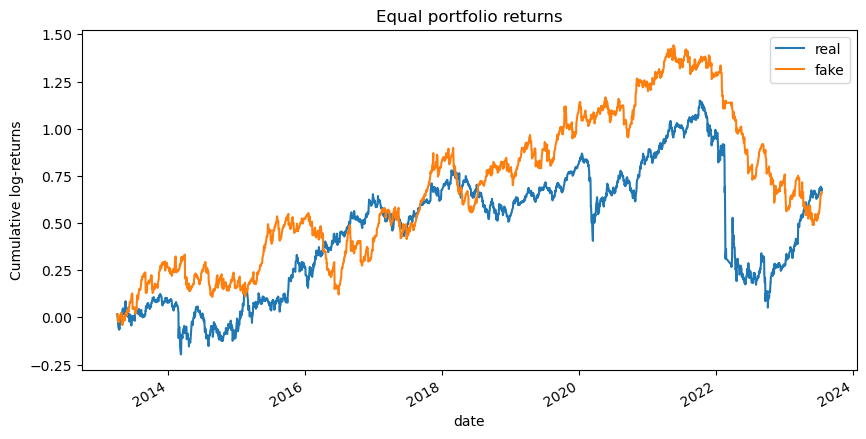

In [49]:
def plot_strategy_on_both_returns(real_returns: pd.Series, fake_returns: pd.Series, title: str):
    plt.figure(figsize=(10, 5))

    real_returns.cumsum().plot(ax=plt.gca(), label='real')
    fake_returns.cumsum().plot(ax=plt.gca(), label='fake')
    plt.title(title)
    plt.ylabel('Cumulative log-returns')
    plt.legend()

    plt.show()


plot_strategy_on_both_returns(equal_w_real_returns, equal_w_fake_returns, 'Equal portfolio returns')

# Momentum portfolio

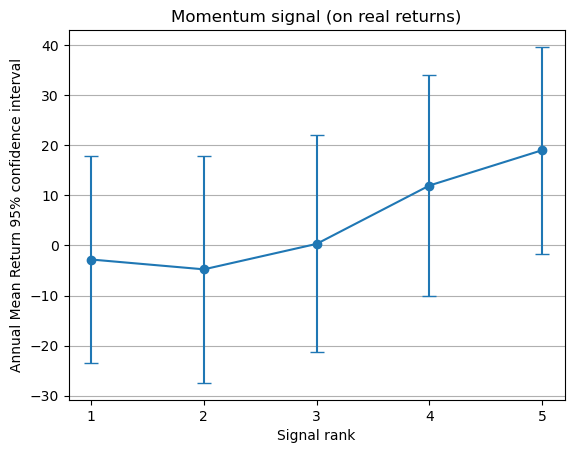

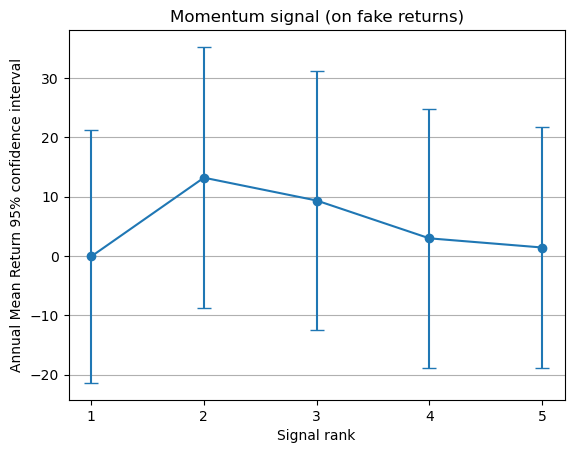

In [38]:
from library.momentum import get_momentum_signal, plot_signal_ranks


def get_momentum_signal_yearly(df_returns: pd.DataFrame) -> pd.DataFrame:
    return get_momentum_signal(df_returns, from_n_days=365, to_n_days=20, from_min_periods=180, to_min_periods=10)


def plot_momentum_signal_ranks(df_returns, title: str):
    df_momentum_signal = get_momentum_signal_yearly(df_returns)
    plot_signal_ranks(df_momentum_signal, df_returns, f'Momentum signal (on {title} returns)')


plot_momentum_signal_ranks(df_returns_real, 'real')
plot_momentum_signal_ranks(df_returns_fake, 'fake')

  0%|          | 0/257600 [00:00<?, ?it/s]

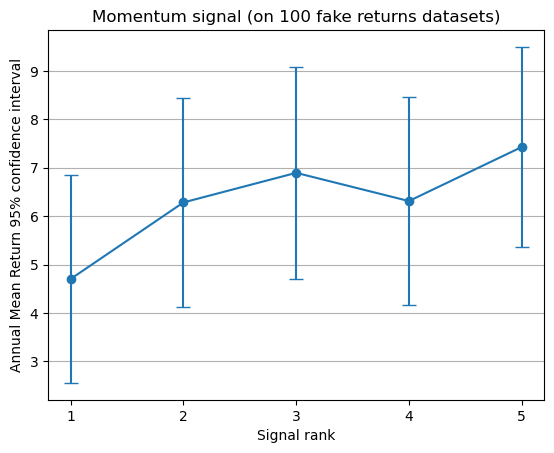

In [43]:
def plot_momentum_signal_ranks_list(df_returns_fake_list: list[pd.DataFrame]):
    df_momentum_signal_list = [get_momentum_signal_yearly(df_returns).reset_index(drop=True) for df_returns in df_returns_fake_list]
    df_momentum_signal = pd.concat(df_momentum_signal_list, axis=0).reset_index(drop=True)
    df_returns_fake = pd.concat(df_returns_fake_list, axis=0).reset_index(drop=True)
    plot_signal_ranks(df_momentum_signal, df_returns_fake, f'Momentum signal (on 100 fake returns datasets)')


plot_momentum_signal_ranks_list(df_returns_fake_list)

Real:
Annual Return (mean ± std): 10.8% ± 28.4%
Sharpe: 0.38
Annual Mean Return 95% confidence interval: 10.78%±18.12%
Fake:
Annual Return (mean ± std): 4.7% ± 27.0%
Sharpe: 0.17
Annual Mean Return 95% confidence interval: 4.67%±17.22%


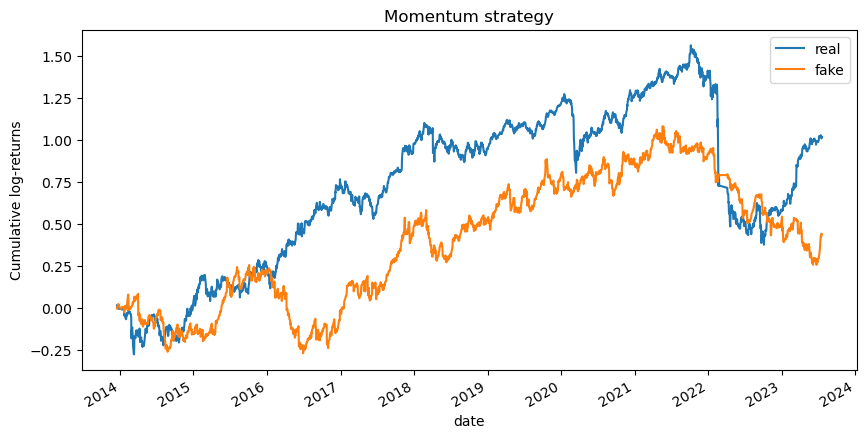

In [50]:
from library.momentum import get_portfolio_from_signal


def get_momentum_signal_returns(df_returns: pd.DataFrame):
    df_momentum_signal = get_momentum_signal_yearly(df_returns)
    df_momentum_weights = get_portfolio_from_signal(df_momentum_signal)
    return get_returns(df_momentum_weights, df_returns)


def plot_momentum_cumulative_returns(df_returns: pd.DataFrame, title: str):
    momentum_returns = get_momentum_signal_returns(df_returns)

    # Print statistics
    print_statistics(momentum_returns)

    # Plot cumulative returns
    plot_cumulative_returns(momentum_returns, f'Momentum portfolio strategy (on {title} returns)')


momentum_returns_real = get_momentum_signal_returns(df_returns_real)
momentum_returns_fake = get_momentum_signal_returns(df_returns_fake)

print('Real:')
print_statistics(momentum_returns_real)

print('Fake:')
print_statistics(momentum_returns_fake)

plot_strategy_on_both_returns(momentum_returns_real, momentum_returns_fake, 'Momentum strategy')

# Markowitz portfolio